- 🛠️ **Install Required Libraries**:
  - **`gensim`** For training the Word2Vec model, which generates word embeddings.
  - **`nltk`** For text preprocessing, including tokenization and handling stopwords.
  - **`bert-score`** For evaluating the similarity between generated and reference summaries.
  - **`pandas`** For handling datasets (reading, processing, and storing).
  - **`matplotlib`** For plotting and visualizing evaluation metrics.

---

In [22]:
!pip install gensim nltk bert-score pandas matplotlib



In [23]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from bert_score import score
import nltk
import re
import string


- 📥 **Download NLTK Resources**:
  - **`punkt`** Provides sentence and word tokenizers.
  - **`stopwords`** Offers a list of common words to exclude during preprocessing.

---

In [26]:

import nltk

# Download 'punkt_tab' package
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **Preprocessing Functions**
- 🧹 **Clean Text**:
  - Removes unnecessary characters like punctuation.
  - Converts text to lowercase to ensure uniformity.
  - Filters out numbers and symbols to retain meaningful content.


- 🛠️ **Prepare DataFrame**:
  - Adds two columns:
    - **`sentences`**: Stores tokenized sentences.
    - **`tokenized_sentences`**: Stores tokenized and cleaned words for each sentence.


---

In [27]:
# Preprocess text to remove punctuation, lowercase, and tokenize
def preprocess_text(text):
    """
    Cleans and tokenizes text.
    Args:
        text (str): Input text to process.
    Returns:
        list: A list of clean tokens.
    """
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text.lower())  # Remove punctuation, lowercase
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]  # Keep only alphabetic tokens
    return tokens

# Preprocess a DataFrame column and tokenize sentences
def preprocess_dataframe(df, text_column):
    """
    Tokenizes text into sentences and words.
    Args:
        df (DataFrame): Input DataFrame.
        text_column (str): Column name containing text data.
    Returns:
        DataFrame: The modified DataFrame with tokenized sentences.
    """
    df['sentences'] = df[text_column].apply(sent_tokenize)  # Sentence tokenization
    df['tokenized_sentences'] = df['sentences'].apply(lambda x: [preprocess_text(sent) for sent in x])
    return df


### **Load and Preprocess Datasets**

- 📂 **Load and Process Data**:
  - Reads CSV files containing articles and their reference summaries.
  - Preprocesses the `article` column for both datasets to tokenize and clean the text.

---

In [28]:
# Load your dataset
test_file_path = 'drive/MyDrive/NLP/project/data/test.csv'
validation_file_path = 'drive/MyDrive/NLP/project/data/validation.csv'

test_data = pd.read_csv(test_file_path)
validation_data = pd.read_csv(validation_file_path)

# Preprocess the dataset
test_data = preprocess_dataframe(test_data, 'article')  # Assume 'article' contains text data
validation_data = preprocess_dataframe(validation_data, 'article')

# Preview the data
print(test_data.head())


                                             article  \
0  anxiety affects quality of life in those livin...   
1  small non - coding rnas are transcribed into m...   
2  ohss is a serious complication of ovulation in...   
3  congenital adrenal hyperplasia ( cah ) refers ...   
4  type 1 diabetes ( t1d ) results from the destr...   

                                            abstract  \
0  research on the implications of anxiety in par...   
1  small non - coding rnas include sirna , mirna ...   
2  objective : to evaluate the efficacy and safet...   
3  congenital adrenal hyperplasia is a group of a...   
4  objective(s):pentoxifylline is an immunomodula...   

                                           sentences  \
0  [anxiety affects quality of life in those livi...   
1  [small non - coding rnas are transcribed into ...   
2  [ohss is a serious complication of ovulation i...   
3  [congenital adrenal hyperplasia ( cah ) refers...   
4  [type 1 diabetes ( t1d ) results from the d

In [30]:
print(all_sentences[:10])  # Preview the first 10 entries


[['anxiety', 'affects', 'quality', 'of', 'life', 'in', 'those', 'living', 'with', 'parkinson', 's', 'disease', 'pd', 'more', 'so', 'than', 'overall', 'cognitive', 'status', 'motor', 'deficits', 'apathy', 'and', 'depression'], ['although', 'anxiety', 'and', 'depression', 'are', 'often', 'related', 'and', 'coexist', 'in', 'pd', 'patients', 'recent', 'research', 'suggests', 'that', 'anxiety', 'rather', 'than', 'depression', 'is', 'the', 'most', 'prominent', 'and', 'prevalent', 'mood', 'disorder', 'in', 'pd'], ['yet', 'our', 'current', 'understanding', 'of', 'anxiety', 'and', 'its', 'impact', 'on', 'cognition', 'in', 'pd', 'as', 'well', 'as', 'its', 'neural', 'basis', 'and', 'best', 'treatment', 'practices', 'remains', 'meager', 'and', 'lags', 'far', 'behind', 'that', 'of', 'depression'], ['overall', 'neuropsychiatric', 'symptoms', 'in', 'pd', 'have', 'been', 'shown', 'to', 'be', 'negatively', 'associated', 'with', 'cognitive', 'performance'], ['for', 'example', 'higher', 'depression', 'sc

In [31]:
# Combine tokenized sentences from both datasets
all_sentences = test_data['tokenized_sentences'].explode().tolist() + validation_data['tokenized_sentences'].explode().tolist()

# Filter out invalid entries
all_sentences = [sentence for sentence in all_sentences if isinstance(sentence, list) and len(sentence) > 0]

# Check the filtered sentences
print(f"Number of valid sentences: {len(all_sentences)}")


Number of valid sentences: 1338515


In [32]:
def preprocess_dataframe(df, text_column):
    df['sentences'] = df[text_column].apply(lambda x: sent_tokenize(x) if isinstance(x, str) else [])
    df['tokenized_sentences'] = df['sentences'].apply(lambda x: [preprocess_text(sent) for sent in x if isinstance(sent, str)])
    return df


### **Train Word2Vec Model**

#### **Parameters**


1. **`sentences=all_sentences`**
   - **Description**: Input data for training the Word2Vec model. This parameter expects a list of tokenized sentences where each sentence is a list of words.
  

2. **`vector_size=100`**
   - **Description**: Specifies the dimensionality of the word vectors (i.e., how many numbers represent each word in the vector space).
   - **Impact**:
     - A **larger vector size** can capture more semantic nuances but requires more memory and computation.
     - A **smaller vector size** is computationally efficient but may miss some semantic details.
   - **Typical Values**: 50, 100, 300.
   - **In this case**: Each word is represented by a 100-dimensional vector.

3. **`window=5`**
   - **Description**: The maximum distance between the current word and its neighboring words to be considered in the context.


4. **`min_count=2`**
   - **Description**: Ignores all words with a total frequency lower than this value.


5. **`workers=4`**
   - **Description**: The number of CPU cores to use for parallel training.


In [33]:
# Train Word2Vec model
model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Save the trained model
model.save("drive/MyDrive/NLP/pubmed_word2vec_train.model")


In [34]:
print(f"Vocabulary size: {len(model.wv.index_to_key)}")  # Print the size of the vocabulary
print(f"Sample words: {model.wv.index_to_key[:10]}")  # Preview some words in the vocabulary


Vocabulary size: 135221
Sample words: ['the', 'of', 'and', 'in', 'to', 'a', 'with', 'for', 'was', 'is']


In [37]:
def summarize_text(text, model, top_n=5):
    """
    Summarizes the given text by extracting the top_n most representative sentences.

    Args:
        text (str): The input text to summarize.
        model (Word2Vec): A pre-trained Word2Vec model.
        top_n (int): Number of sentences to include in the summary.

    Returns:
        list: A list of the top_n most representative sentences.
    """
    sentences = sent_tokenize(text)
    sentence_vectors = []

    for sentence in sentences:
        # Tokenize and filter words in the Word2Vec vocabulary
        words = [word for word in word_tokenize(sentence.lower()) if word in model.wv]

        # Skip sentences with no valid words
        if not words:
            continue

        # Compute the sentence vector as the mean of word embeddings
        vector = np.mean([model.wv[word] for word in words], axis=0)

        # Skip invalid vectors (e.g., NaN values)
        if np.isnan(vector).any():
            continue

        sentence_vectors.append((sentence, vector))

    if not sentence_vectors:
        return ["No valid summary could be generated."]

    # Compute the centroid vector
    centroid = np.mean([vec for _, vec in sentence_vectors], axis=0)

    # Rank sentences by their similarity to the centroid
    ranked_sentences = sorted(sentence_vectors, key=lambda x: np.dot(x[1], centroid), reverse=True)

    # Limit the number of sentences in the summary
    return [sentence for sentence, _ in ranked_sentences[:top_n]]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 1/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 2/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 3/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 4/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 5/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 6/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 7/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 8/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 9/10 articles


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 10/10 articles


<ipython-input-39-407dece39199>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_limited['generated_summary'] = generated_summaries
<ipython-input-39-407dece39199>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_limited['Precision'] = precision_scores
<ipython-input-39-407dece39199>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

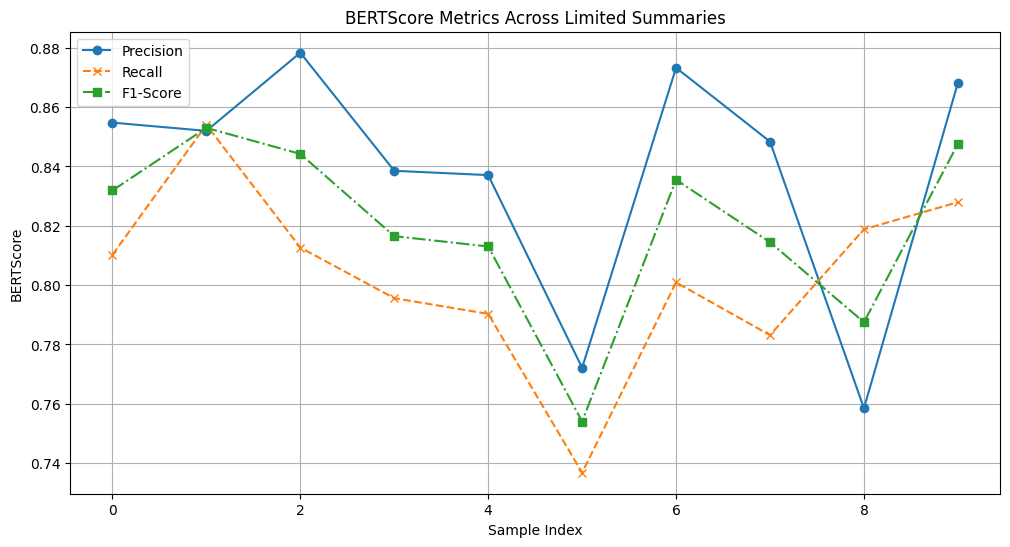

In [39]:
# Step 1: Limit the dataset
test_data_limited = test_data.head(10)  # Process the first 10 rows (or use sample for random rows)

# Step 2: Initialize lists for storing results
generated_summaries = []
precision_scores = []
recall_scores = []
f1_scores = []

# Step 3: Summarization and evaluation loop
for i, row in test_data_limited.iterrows():
    article_text = row['article']  # Input article text
    reference_summary = row['abstract']  # Ground truth summary

    # Generate a summary with a limit of 3 sentences
    summary_sentences = summarize_text(article_text, model, top_n=3)
    generated_summary = " ".join(summary_sentences)
    generated_summaries.append(generated_summary)

    # Compute BERTScore
    P, R, F1 = score([generated_summary], [reference_summary], lang="en", verbose=False)
    precision_scores.append(P.mean().item())
    recall_scores.append(R.mean().item())
    f1_scores.append(F1.mean().item())

    # Print progress
    print(f"Processed {i+1}/{len(test_data_limited)} articles")

# Step 4: Add results to the limited DataFrame
test_data_limited['generated_summary'] = generated_summaries
test_data_limited['Precision'] = precision_scores
test_data_limited['Recall'] = recall_scores
test_data_limited['F1-Score'] = f1_scores

# Step 5: Plot the metrics
plt.figure(figsize=(12, 6))
plt.plot(range(len(precision_scores)), precision_scores, marker='o', label='Precision', linestyle='-')
plt.plot(range(len(recall_scores)), recall_scores, marker='x', label='Recall', linestyle='--')
plt.plot(range(len(f1_scores)), f1_scores, marker='s', label='F1-Score', linestyle='-.')

# Add labels and title
plt.title('BERTScore Metrics Across Limited Summaries')
plt.xlabel('Sample Index')
plt.ylabel('BERTScore')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Save the limited results
output_file_path = 'drive/MyDrive/NLP/project/data/limited_test_with_summaries_and_bertscore.csv'
test_data_limited.to_csv(output_file_path, index=False)


In [42]:
test_data_limited = pd.read_csv(output_file_path)

# Display the first few rows of the DataFrame to verify content
test_data_limited.head()
for index, row in test_data_limited.iterrows():
    print(f"\n=== Article {index + 1} ===")
    print(f"Generated Summary: {row['generated_summary']}")
    print(f"Reference Summary: {row['abstract']}")
    print(f"Precision: {row['Precision']:.4f}, Recall: {row['Recall']:.4f}, F1-Score: {row['F1-Score']:.4f}")
    print("=" * 50)



=== Article 1 ===
Generated Summary: , attention ) [ 1014 ] . anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression [ 13 ] . , immediate memory , visuospatial construction , language , attention , and delayed memory ) .
Reference Summary: research on the implications of anxiety in parkinson 's disease ( pd ) has been neglected despite its prevalence in nearly 50% of patients and its negative impact on quality of life . 
 previous reports have noted that neuropsychiatric symptoms impair cognitive performance in pd patients ; however , to date , no study has directly compared pd patients with and without anxiety to examine the impact of anxiety on cognitive impairments in pd . 
 this study compared cognitive performance across 50 pd participants with and without anxiety ( 17 pda+ ; 33 pda ) , who underwent neurological and neuropsychological assessment . 
 group performance was co